# Assignment 3

## Exercise 2

Global minimum variance portfolio implicitly assumes that assets have positive definite covariance matrix and since the weights has no influence from the mean, there is no restriction.

The risk parity portfolio implicitly assumes that assets have positive definite covariance matrix and the mean should have little inherent uncertainty.

The equally weighted portfolio implicitly assumes that assets have positive definite covariance matrix and the mean should have little inherent uncertainty, and follows normal distribution.


In [2]:
import wrds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
db = wrds.Connection()
db.create_pgpass_file()

Enter your WRDS username [felicity]:alina925
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [ ]:
#Get stocks
stock1=db.raw_sql("select date, ret from crsp.msf where permno in (11308) and date>='1978-01-01' and date<='2020-12-31'")
stock1.to_csv('stock1.csv')

stock2=db.raw_sql("select date, ret from crsp.msf where permno in (11850) and date>='1978-01-01' and date<='2020-12-31'")
stock2.to_csv('stock2.csv')

stock3=db.raw_sql("select date, ret from crsp.msf where permno in (12490) and date>='1978-01-01' and date<='2020-12-31'")
stock3.to_csv('stock3.csv')

stock4=db.raw_sql("select date, ret from crsp.msf where permno in (14541) and date>='1978-01-01' and date<='2020-12-31'")
stock4.to_csv('stock4.csv')

stock5=db.raw_sql("select date, ret from crsp.msf where permno in (17830) and date>='1978-01-01' and date<='2020-12-31'")
stock5.to_csv('stock5.csv')

stock6=db.raw_sql("select date, ret from crsp.msf where permno in (18163) and date>='1978-01-01' and date<='2020-12-31'")
stock6.to_csv('stock6.csv')

stock7=db.raw_sql("select date, ret from crsp.msf where permno in (18542) and date>='1978-01-01' and date<='2020-12-31'")
stock7.to_csv('stock7.csv')

stock8=db.raw_sql("select date, ret from crsp.msf where permno in (19502) and date>='1978-01-01' and date<='2020-12-31'")
stock8.to_csv('stock8.csv')

stock9=db.raw_sql("select date, ret from crsp.msf where permno in (19561) and date>='1978-01-01' and date<='2020-12-31'")
stock9.to_csv('stock9.csv')

stock10=db.raw_sql("select date, ret from crsp.msf where permno in (21936) and date>='1978-01-01' and date<='2020-12-31'")
stock10.to_csv('stock10.csv')

stock11=db.raw_sql("select date, ret from crsp.msf where permno in (22111) and date>='1978-01-01' and date<='2020-12-31'")
stock11.to_csv('stock11.csv')

stock12=db.raw_sql("select date, ret from crsp.msf where permno in (22592) and date>='1978-01-01' and date<='2020-12-31'")
stock12.to_csv('stock12.csv')

stock13=db.raw_sql("select date, ret from crsp.msf where permno in (22752) and date>='1978-01-01' and date<='2020-12-31'")
stock13.to_csv('stock13.csv')

stock14=db.raw_sql("select date, ret from crsp.msf where permno in (26403) and date>='1978-01-01' and date<='2020-12-31'")
stock14.to_csv('stock14.csv')

stock15=db.raw_sql("select date, ret from crsp.msf where permno in (43449) and date>='1978-01-01' and date<='2020-12-31'")
stock15.to_csv('stock15.csv')

stock16=db.raw_sql("select date, ret from crsp.msf where permno in (47896) and date>='1978-01-01' and date<='2020-12-31'")
stock16.to_csv('stock16.csv')

stock17=db.raw_sql("select date, ret from crsp.msf where permno in (55976) and date>='1978-01-01' and date<='2020-12-31'")
stock17.to_csv('stock17.csv')

stock18=db.raw_sql("select date, ret from crsp.msf where permno in (59176) and date>='1978-01-01' and date<='2020-12-31'")
stock18.to_csv('stock18.csv')

stock19=db.raw_sql("select date, ret from crsp.msf where permno in (59328) and date>='1978-01-01' and date<='2020-12-31'")
stock19.to_csv('stock19.csv')

stock20=db.raw_sql("select date, ret from crsp.msf where permno in (59459) and date>='1978-01-01' and date<='2020-12-31'")
stock20.to_csv('stock20.csv')

In [5]:
#Read stocks
stock = pd.read_csv('stock1.csv', index_col=0)
s2 = pd.read_csv('stock2.csv', usecols=['ret']).squeeze()
s3 = pd.read_csv('stock3.csv', usecols=['ret']).squeeze()
s4 = pd.read_csv('stock4.csv', usecols=['ret']).squeeze()
s5 = pd.read_csv('stock5.csv', usecols=['ret']).squeeze()
s6 = pd.read_csv('stock6.csv', usecols=['ret']).squeeze()
s7 = pd.read_csv('stock7.csv', usecols=['ret']).squeeze()
s8 = pd.read_csv('stock8.csv', usecols=['ret']).squeeze()
s9 = pd.read_csv('stock9.csv', usecols=['ret']).squeeze()
s10 = pd.read_csv('stock10.csv', usecols=['ret']).squeeze()
s11 = pd.read_csv('stock11.csv', usecols=['ret']).squeeze()
s12 = pd.read_csv('stock12.csv', usecols=['ret']).squeeze()
s13 = pd.read_csv('stock13.csv', usecols=['ret']).squeeze()
s14 = pd.read_csv('stock14.csv', usecols=['ret']).squeeze()
s15 = pd.read_csv('stock15.csv', usecols=['ret']).squeeze()
s16 = pd.read_csv('stock16.csv', usecols=['ret']).squeeze()
s17 = pd.read_csv('stock17.csv', usecols=['ret']).squeeze()
s18 = pd.read_csv('stock18.csv', usecols=['ret']).squeeze()
s19 = pd.read_csv('stock19.csv', usecols=['ret']).squeeze()
s20 = pd.read_csv('stock20.csv', usecols=['ret']).squeeze()

stock.date = pd.to_datetime(stock.date)
ret = pd.DataFrame({'date': stock.date, 's1': stock.ret, 's2':s2,'s3':s3, 's4':s4, 's5':s5, 's6':s6, 's7':s7,
                   's8':s8, 's9':s9, 's10':s10, 's11':s11, 's12':s12, 's13':s13, 's14':s14, 's15':s15,
                   's16':s16, 's17':s17, 's18':s18, 's19':s19, 's20':s20 })
ret = ret.set_index('date')

In [6]:
rf = pd.read_csv('rf.csv', usecols=['tmytm']).squeeze()
#Compute the monthly simple rate
rf_m = (np.exp(rf/100)-1)/12

#### a)

Functions for different portfolio weights

In [7]:
#tangency portfolio
def w_tan(cov, mu, rf):
    cov_inv = np.linalg.inv(cov)
    A = cov_inv.sum()
    B = cov_inv.sum(0) @ mu
    w = (cov_inv @ (mu-rf))/(B-A*rf)
    return w

#global minimum-variance portfolio
def w_min(cov):
    cov_inv = np.linalg.inv(cov)
    return cov_inv.sum(1)/cov_inv.sum()

#risk parity portfolio
def w_rp(rets):
    sd = np.apply_along_axis(np.std, 0, rets)
    sd_inv = 1/sd
    return sd_inv/sd_inv.sum()

#equally weighted portfolio
def w_ew(rets):
    n = rets.shape[1]
    return np.full(n,1/n)

Loop set-up, create portfolio monthly returns array

In [8]:
trade_months = (2020-1988+1)*12
trade_periods = range(120,ret.shape[0])
n = ret.shape[1]
pfs_rets = np.empty((trade_months,4))

Compute monthly rebalanced returns with 10-year rolling window

In [9]:
for i in trade_periods:
    train = ret.iloc[(i-120):i,:]
    rets = np.array(ret.iloc[i,:])
    cov = np.cov(train, rowvar=False)
    mu = np.apply_along_axis(np.mean, 0, train)
    rff = rf_m[i-120]
    
    wtan = w_tan(cov,mu,rff)
    wmin = w_min(cov)
    wrp = w_rp(train)
    wew = w_ew(train)
    
    W = np.stack((wtan,wmin,wrp,wew), axis=1)
    pfs_ret = rets @ W
    pfs_rets[i-120,:] = pfs_ret
       

In [10]:
# there are some abnormal values (<-1) for the TAN pf
tan = pfs_rets[:,0]
a = tan < -1
outl = []
for i in range(len(a)):
    if a[i] == True:
        outl.append(i)

# replace them by 0
pfs_rets[outl,0] = 0

Numpy array to pandas dataframe

In [11]:
pf_dates = ret.index
pf_dates = pf_dates[120:]
pfs_rets_df = pd.DataFrame(pfs_rets)
pfs_rets_df['date'] = pf_dates
pfs_rets_df = pfs_rets_df.set_index('date')
pfs_rets_df = pfs_rets_df.rename(columns={0:'TAN',1:'MIN',2:'RP',3:'EW'})
pfs_rets_df

,TAN,MIN,RP,EW
date,,,,
1988-01-29,-0.160205,0.018610,0.037312,0.041143
1988-02-29,0.093124,0.011767,0.044241,0.048118
1988-03-31,0.081497,-0.057729,-0.034916,-0.032432
1988-04-29,0.047814,0.038754,0.016548,0.016976
1988-05-31,0.081039,0.018833,0.021081,0.023103
...,...,...,...,...
2020-08-31,0.151606,0.075923,0.052117,0.050741
2020-09-30,0.068692,0.021074,-0.027456,-0.030192
2020-10-30,-0.057397,-0.049000,-0.035461,-0.036529


In [12]:
pf_mu = pfs_rets_df.apply(np.mean, axis=0)
pf_sd = pfs_rets_df.apply(np.std, axis=0)
print('Mean return of portfolios (in %):',pf_mu*100,sep='\n')
print('\nStd of returns of portfolios (in %):',pf_sd*100,sep='\n')

rf_mu = rf_m.mean()
pf_sr = ((pf_mu-rf_mu)/pf_sd)*np.sqrt(12)
print('\nSharpe ratios of portfolios:', pf_sr, sep='\n')

Mean return of portfolios (in %):
TAN    3.460854
MIN    0.860826
RP     1.166221
EW     1.206063
dtype: float64

Std of returns of portfolios (in %):
TAN    41.534356
MIN     3.834793
RP      3.987687
EW      4.161575
dtype: float64

Sharpe ratios of portfolios:
TAN    0.258595
MIN    0.452126
RP     0.700086
EW     0.703999
dtype: float64


#### b）

The tangency portfolio has the largest mean return, while at the same time, the largest variance.
The global minimum-variance portfolio has the smallest mean return, and the smallest variance. 
This is owing to the fact that portafolio with higher risks are typically with higher mean expected return.
Considering how much excess return you may get in taking the extra risk, we look at the Sharpe ratio. Comparing the four portfolios, the risk parity portfolio and the equally weighted portfolio has a larger Sharpe ratio, in other words, more favorable for investors.


#### c)

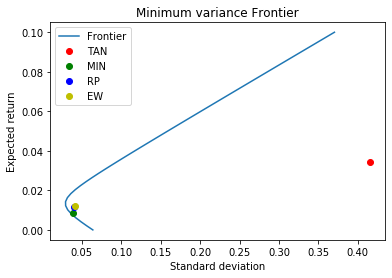

In [42]:
# Actually the data used is until 2020, instead of 2018 for convenience
mu = np.apply_along_axis(np.mean, 0, ret)
cov_inv = np.linalg.inv(cov)
A = cov_inv.sum()
B = cov_inv.sum(0) @ mu
C = np.matrix.transpose(mu) @ cov_inv @ mu
D = A*C - B**2

#plot of minimum variance frontier
mu_p = np.linspace(0, 0.1, 50, endpoint=True)
sigma_p = np.sqrt((A*mu_p**2 - 2*B*mu_p + C)/D)

plt.plot(sigma_p,mu_p,label="Frontier")
plt.xlabel('Standard deviation')
plt.ylabel('Expected return')
plt.title('Minimum variance Frontier')
plt.plot(pf_sd[0],pf_mu[0],"ro", label="TAN")
plt.plot(pf_sd[1],pf_mu[1],"go", label="MIN")
plt.plot(pf_sd[2],pf_mu[2],"bo", label="RP")
plt.plot(pf_sd[3],pf_mu[3],"yo", label="EW")
plt.legend()
plt.show()

In the plot, we can see that all the four portfolios are to the right of the minimum variance frontier. Ideally, the tangency portfolio should be on the frontier. In this task, we have 20 stocks, and therefore, quite a couple of parameters to optimize. Then, due to the existence of outliers, it is unstable. Except for the tangency portfolio, the other three portfolios have quite similar ex post performances, i.e. they have similar expected return as well as standard deviation.

#### d)

In [91]:
row = pfs_rets_df.shape[0]
r_tbill = np.array(rf_m[(rf_m.shape[0]-pfs_rets_df.shape[0]):rf_m.shape[0]])

cul = np.ones((row+1,5))
r_port = np.array(pfs_rets_df)

In [95]:
for j in range(row):
    cul[(j+1,0)] = cul[(j,0)]*(1+r_tbill[j])
    cul[(j+1,1)] = cul[(j,1)]*(1+r_port[(j,0)])
    cul[(j+1,2)] = cul[(j,2)]*(1+r_port[(j,1)])
    cul[(j+1,3)] = cul[(j,3)]*(1+r_port[(j,2)])
    cul[(j+1,4)] = cul[(j,4)]*(1+r_port[(j,3)])
    

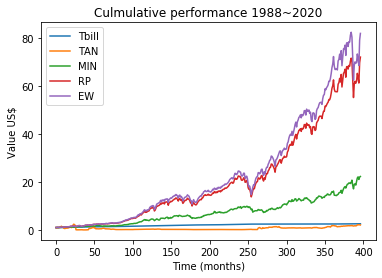

In [102]:
#plot
plt.plot(cul[:,0],label="Tbill")
plt.plot(cul[:,1], label="TAN")
plt.plot(cul[:,2], label="MIN")
plt.plot(cul[:,3], label="RP")
plt.plot(cul[:,4], label="EW")
plt.xlabel('Time (months)')
plt.ylabel('Value US$')
plt.title('Culmulative performance 1988~2020')
plt.legend()
plt.show()